# Version 6: (μ, λ) Evolutionary Strategies
* Implement the (μ, λ) version of ES, where the next generation is selected only
from the offspring population, introducing greater selection pressure.

In [1]:
# Importing necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from statisticscalc import analyze_convergence, validate_and_plot

In [ ]:
# Load monthly returns data
monthly_returns_df = pd.read_csv('data/monthlyreturn/monthlyreturnstocks.csv')
monthly_returns_df = monthly_returns_df.select_dtypes(include=[np.number])

# Define parameters
population_size = 50  # μ
offspring_size = 100  # λ
num_generations = 1000
mutation_rate = 0.1
num_months = len(monthly_returns_df)  # Total months
num_assets = monthly_returns_df.shape[1]  # Total stocks


# Calculate the covariance matrix for risk analysis
cov_matrix = monthly_returns_df.cov().to_numpy()

In [ ]:
def initialize_population(size, num_months, num_assets):
    population = []
    mutation_steps = []
    for _ in range(size):
        # Each portfolio is a matrix where each row (month) sums to 1
        portfolio = np.array([np.random.dirichlet(np.ones(num_assets)) for _ in range(num_months)])
        population.append(portfolio)
        # Self-adaptive mutation steps initialized
        mutation_steps.append(np.full((num_months, num_assets), mutation_rate))
    return np.array(population), np.array(mutation_steps)

def adaptive_mutation(portfolio, mutation_steps, individual_fitness, best_fitness, worst_fitness, min_rate=0.01, max_rate=0.5):
    fitness_normalized = (individual_fitness - worst_fitness) / (best_fitness - worst_fitness) if best_fitness != worst_fitness else 0.5
    mutation_rate = min_rate + (max_rate - min_rate) * (1 - fitness_normalized)
    mutation_rate = max(mutation_rate, 0.01)

    for month in range(num_months):
        mutation_steps[month] *= np.exp(np.random.normal(0, mutation_rate, size=mutation_steps[month].shape))
        mutation = np.random.normal(0, mutation_steps[month], size=portfolio[month].shape)
        portfolio[month] += mutation
        portfolio[month] = np.abs(portfolio[month])
        portfolio[month] /= portfolio[month].sum()
    
    return portfolio, mutation_steps

def blend_crossover(parent1, parent2, sigma1, sigma2, alpha=0.5):
    child_portfolio = np.zeros_like(parent1)
    child_sigma = np.zeros_like(sigma1)
    for month in range(parent1.shape[0]):
        min_weight = np.minimum(parent1[month], parent2[month])
        max_weight = np.maximum(parent1[month], parent2[month])
        range_extension = (max_weight - min_weight) * alpha
        child_portfolio[month] = min_weight + np.random.uniform(0, 1) * (max_weight - min_weight + range_extension)
        child_sigma[month] = (sigma1[month] + sigma2[month]) / 2
    child_portfolio /= child_portfolio.sum(axis=1, keepdims=True)
    return child_portfolio, child_sigma

# Fitness function with cumulative compounding and risk penalty
def calculate_fitness_cov(portfolio, risk_tolerance=0.1):
    """
    Calculates each month's return and compounds it.
    Adds a penalty for risk based on the portfolio's variance using the covariance matrix.
    """
    monthly_returns = monthly_returns_df.to_numpy()  # Assuming this DataFrame is pre-loaded
    cumulative_growth = 1.0  # Start with an initial growth factor of 1 (100%)
    portfolio_risk_total = 0  # Accumulate portfolio risk for all months
    
    # Calculate cumulative return and risk
    for month in range(portfolio.shape[0]):
        month_weights = portfolio[month]
        
        # Calculate monthly return
        month_return = np.dot(month_weights, monthly_returns[month])  # Weighted return for this month
        cumulative_growth *= (1 + month_return / 100)  # Compound growth with this month's return
        
        # Calculate portfolio variance (risk) using the covariance matrix
        month_variance = np.dot(month_weights.T, np.dot(cov_matrix, month_weights))
        month_risk = np.sqrt(month_variance)  # Risk as standard deviation
        portfolio_risk_total += month_risk

    # Final cumulative return as a percentage
    cumulative_return = (cumulative_growth - 1) * 100  # Represent as percentage

    # Adjust fitness to include risk (penalize high-risk portfolios)
    fitness_score = cumulative_return - risk_tolerance * portfolio_risk_total
    return fitness_score

def tournament_selection(population, fitness_scores, mutation_steps, num_parents=2, tournament_size=3):
    selected_parents = []
    selected_sigmas = []
    for _ in range(num_parents):
        competitors = np.random.choice(len(fitness_scores), tournament_size, replace=False)
        best_index = max(competitors, key=lambda idx: fitness_scores[idx])
        selected_parents.append(population[best_index])
        selected_sigmas.append(mutation_steps[best_index])
    return selected_parents, selected_sigmas


In [20]:
# Evolutionary Strategy with tournament selection, blend crossover, adaptive mutation, and offspring-only selection
def evolutionary_strategy_optimization(population_size, offspring_size, num_generations, num_months, num_assets):
    start_time = time.time()
    
    # Step 1: Initialize the initial population and mutation steps
    population, mutation_steps = initialize_population(population_size, num_months, num_assets)
    generation_plot = []  # List to store the best return for each generation

    # Step 2: Evolution loop
    for generation in range(num_generations):
        # Calculate fitness scores for each portfolio in the population
        fitness_scores = np.array([calculate_fitness_cov(portfolio) for portfolio in population])
        best_fitness = np.max(fitness_scores)
        worst_fitness = np.min(fitness_scores)

        # Step 3: Generate offspring using blend crossover and adaptive mutation
        offspring = []
        offspring_sigmas = []
        for _ in range(offspring_size):
            # Select two parents using tournament selection
            parents, sigmas = tournament_selection(population, fitness_scores, mutation_steps)
            # Create a child by blending traits of both parents
            child_portfolio, child_sigma = blend_crossover(parents[0], parents[1], sigmas[0], sigmas[1])
            # Apply adaptive mutation to introduce variation
            child_fitness = calculate_fitness_cov(child_portfolio)
            mutated_portfolio, mutated_sigma = adaptive_mutation(child_portfolio.copy(), child_sigma.copy(), 
                                                                 child_fitness, best_fitness, worst_fitness)
            offspring.append(mutated_portfolio)
            offspring_sigmas.append(mutated_sigma)

        # Step 4: Select top individuals from offspring to form the next generation
        offspring_fitness = np.array([calculate_fitness_cov(ind) for ind in offspring])  # Fitness of offspring only
        # Select the best-performing offspring to become the new population
        top_indices = np.argsort(offspring_fitness)[-population_size:]
        population = np.array([offspring[i] for i in top_indices])
        mutation_steps = np.array([offspring_sigmas[i] for i in top_indices])

        # Track the best return for this generation for analysis
        best_return = np.max(offspring_fitness)
        generation_plot.append(best_return)

        # Print progress every 100 generations
        if generation % 100 == 0:
            print(f"Generation {generation}: Best Cumulative Return = {best_return:.4f}")

    # Step 5: Identify the best portfolio from the final generation
    best_portfolio = population[np.argmax([calculate_fitness_cov(portfolio) for portfolio in population])]
    end_time = time.time() - start_time

    return best_portfolio, generation_plot, best_return, end_time


Generation 0: Best Cumulative Return = 125.4449
Generation 100: Best Cumulative Return = 5398.5838
Generation 200: Best Cumulative Return = 71133.4189
Generation 300: Best Cumulative Return = 225683.8326
Generation 400: Best Cumulative Return = 299701.5511
Generation 500: Best Cumulative Return = 336357.3339
Generation 600: Best Cumulative Return = 351946.2358
Generation 700: Best Cumulative Return = 372066.8284
Generation 800: Best Cumulative Return = 389112.4420
Generation 900: Best Cumulative Return = 399994.6439
Convergence achieved at generation: 936
Time to convergence: 311.40 seconds
Best Return: 400641.1104248554
Total Time: 332.70 seconds
All monthly allocations sum to 1.


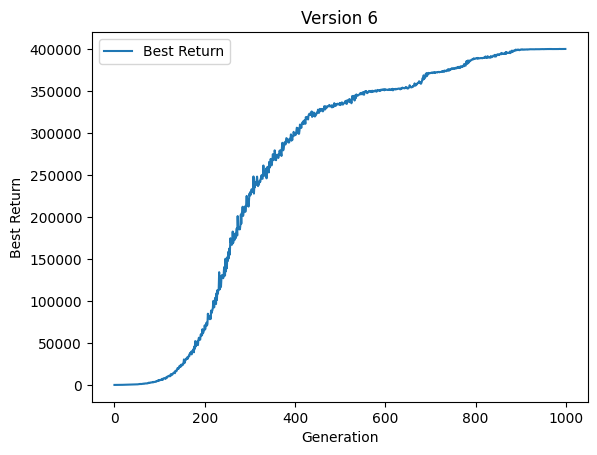

In [21]:
# Run the (μ, λ) Evolutionary Strategy optimization
best_portfolio, generation_plot, best_return, end_time = evolutionary_strategy_optimization(population_size, offspring_size, num_generations, num_months, num_assets)

analyze_convergence(generation_plot, end_time)
# Display final results
print("Best Return:", best_return)
print(f"Total Time: {end_time:.2f} seconds")
validate_and_plot(best_portfolio, generation_plot, num_months, title="Version 6", output_file="results/Version_6.png")